Loading CBG data...
CBGs loaded: 242298
Filtering to LA County CBGs only...
LA County CBGs: 0
✓ LA County CBGs saved as 'la_county_cbgs.geojson' in WGS84 for mapping
ERROR: No LA County CBGs found. Check GEOID format.
Sample GEOIDs: 0    011130303001
1    040159534062
2    040019450021
3    040270003012
4    050070208033
Name: GEOID, dtype: object
Alternative filter found: 6587 CBGs
Converting CBGs to projected CRS...
CBG CRS: EPSG:3310

SCAG PARCEL DATA ANALYSIS
Loading SCAG parcel data...
Total SCAG parcels loaded: 2,406,373
Available columns: ['PID19', 'APN19', 'COUNTY', 'COUNTY_ID', 'CITY', 'CITY_ID', 'MULTIPART', 'STACK', 'ACRES', 'SLOPE', 'GEOID20', 'GP19_CITY', 'GP19_SCAG', 'DEN_AVG', 'DEN_MIN', 'DEN_MAX', 'FAR_AVG', 'FAR_MIN', 'FAR_MAX', 'YEAR_GP', 'SP_INDEX', 'SP_NAME', 'SP19_CITY', 'SP19_SCAG', 'DEN_AVG_SP', 'DEN_MIN_SP', 'DEN_MAX_SP', 'FAR_AVG_SP', 'FAR_MIN_SP', 'FAR_MAX_SP', 'YEAR_SP', 'ZN19_CITY', 'ZN19_SCAG', 'LU19', 'YEAR', 'geometry']
SCAG Commercial parcels: 88,060

SC

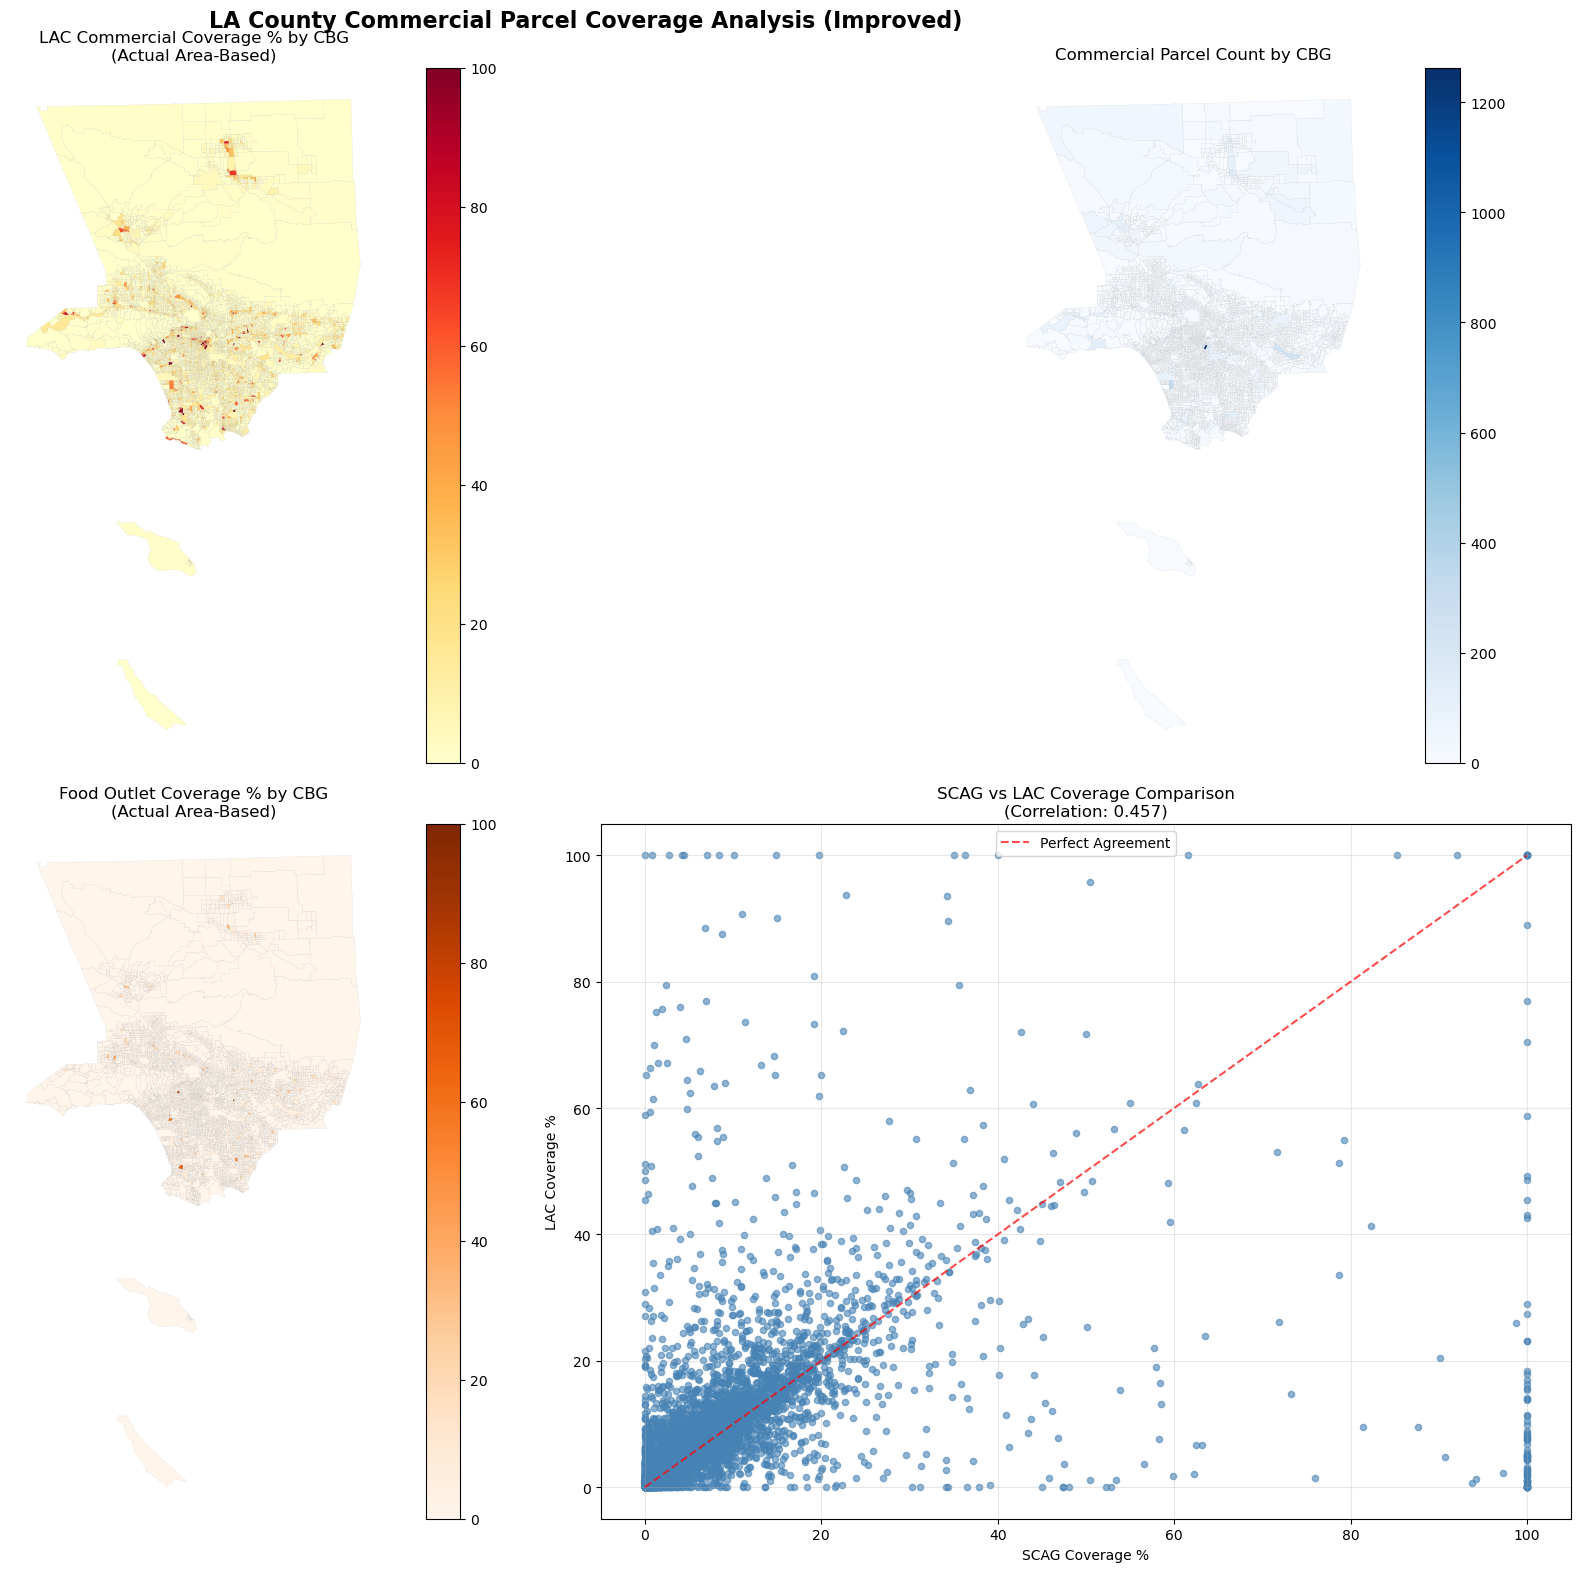

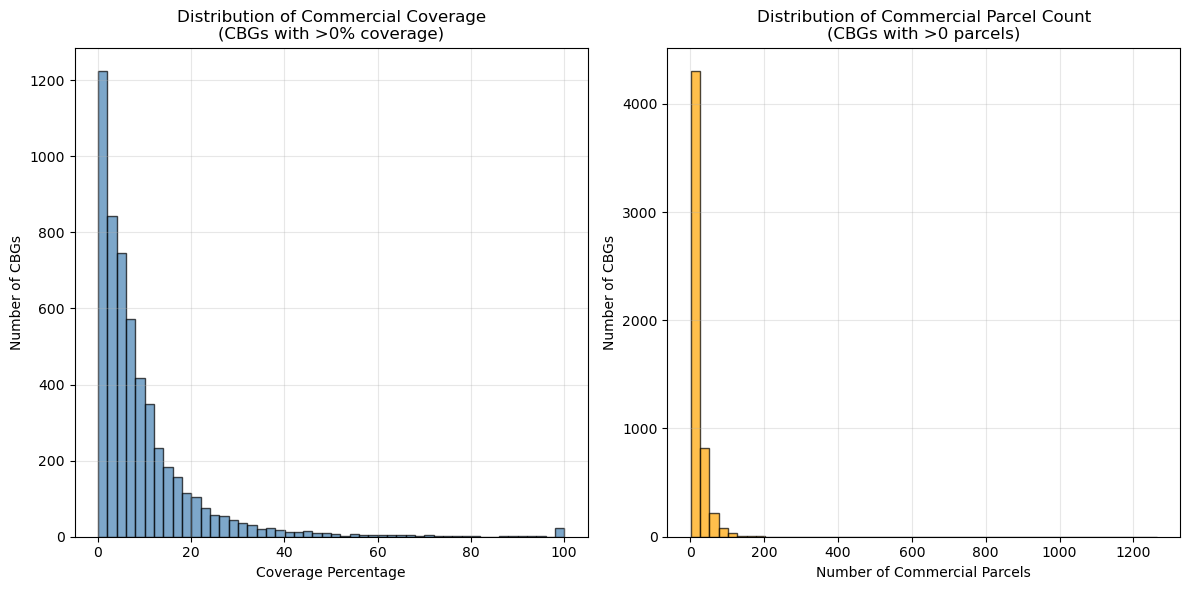


------------------------------------------------------------
SAVING RESULTS AS GEOJSON
------------------------------------------------------------
✓ SCAG coverage analysis saved as 'scag_commercial_coverage_by_cbg.geojson'
✓ LAC commercial coverage analysis saved as 'lac_commercial_coverage_by_cbg.geojson'
✓ LAC food coverage analysis saved as 'lac_food_coverage_by_cbg.geojson'
✓ SCAG vs LAC comparison saved as 'scag_lac_coverage_comparison.csv'
✓ SCAG vs LAC comparison with geometries saved as 'scag_lac_coverage_comparison.geojson'
✓ SCAG commercial parcels saved as 'scag_commercial_parcels.geojson'
✓ LAC commercial parcels (sample of 50k) saved as 'lac_commercial_parcels_sample.geojson'
✓ LAC food outlet parcels saved as 'lac_food_outlet_parcels.geojson'

------------------------------------------------------------
GEOJSON ANALYSIS COMPLETE
------------------------------------------------------------

Files created:
1. scag_commercial_coverage_by_cbg.geojson - CBGs with SCAG commer

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CBG data
print("Loading CBG data...")
cbg_gdf = gpd.read_file("/Users/ananyaparikh/Desktop/SCCFED/CBG_files/cb_2023_us_bg_500k.shp")
print(f"CBGs loaded: {len(cbg_gdf)}")

# FILTER TO LA COUNTY ONLY (FIPS: 06037)
print("Filtering to LA County CBGs only...")
la_county_cbgs = cbg_gdf[cbg_gdf['GEOID'].str.startswith('060370')].copy()
print(f"LA County CBGs: {len(la_county_cbgs)}")

# Save LA County CBGs in WGS84 for web mapping
la_county_cbgs_wgs84 = la_county_cbgs.to_crs('EPSG:4326')
la_county_cbgs_wgs84.to_file('la_county_cbgs.geojson', driver='GeoJSON')
print("✓ LA County CBGs saved as 'la_county_cbgs.geojson' in WGS84 for mapping")

if len(la_county_cbgs) == 0:
    print("ERROR: No LA County CBGs found. Check GEOID format.")
    print("Sample GEOIDs:", cbg_gdf['GEOID'].head())
    # Alternative filter attempts
    la_county_cbgs = cbg_gdf[cbg_gdf['GEOID'].str.contains('06037')].copy()
    print(f"Alternative filter found: {len(la_county_cbgs)} CBGs")

# Convert to projected CRS for accurate area calculations
print("Converting CBGs to projected CRS...")
la_county_cbgs = la_county_cbgs.to_crs('EPSG:3310')  # California Albers projection (meters)
print(f"CBG CRS: {la_county_cbgs.crs}")

# =============================================================================
# SCAG DATA ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("SCAG PARCEL DATA ANALYSIS")
print("="*60)

# SCAG data location
scag_file_path = "/Users/ananyaparikh/Desktop/SCCFED/2019_Land_Use/landuse_combined_poly_LA.shp"

try:
    print("Loading SCAG parcel data...")
    scag_gdf = gpd.read_file(scag_file_path)
    
    print(f"Total SCAG parcels loaded: {len(scag_gdf):,}")
    print(f"Available columns: {list(scag_gdf.columns)}")
    
    # column name based on SCAG data structure
    land_use_column = 'LU19'
    
    # SCAG Commercial codes 
    scag_commercial_codes = [
        '1200', '1220', '1221', '1222', '1223', '1230', '1231'  # Known commercial codes
    ]
    
    # Filter for commercial parcels using specific codes
    scag_commercial = scag_gdf[scag_gdf[land_use_column].astype(str).isin(scag_commercial_codes)].copy()
    
    print(f"SCAG Commercial parcels: {len(scag_commercial):,}")
    
    # Convert to same CRS as CBGs
    scag_commercial = scag_commercial.to_crs(la_county_cbgs.crs)
    
    # Analyze commercial land use types
    print("\nSCAG Commercial Land Use Breakdown:")
    commercial_counts = scag_commercial[land_use_column].value_counts()
    print(commercial_counts)
    
    # Create detailed breakdown
    scag_results = []
    for code, count in commercial_counts.items():
        scag_results.append({'Land Use Code': code, 'Amount of Parcels': count})
    
    scag_results_df = pd.DataFrame(scag_results)
    print("\nSCAG Analysis Results:")
    print(scag_results_df)

except Exception as e:
    print(f"Error loading SCAG data: {e}")
    print("Please update the scag_file_path variable with the correct path to your SCAG data")

# =============================================================================
# LAC DATA ANALYSIS  
# =============================================================================
print("\n" + "-"*60)
print("LAC PARCEL DATA ANALYSIS")
print("-"*60)

# LAC data location
lac_file_path = "/Users/ananyaparikh/Desktop/SCCFED/LACounty_Parcels/LACounty_Parcels.shp"

try:
    print("Loading LAC parcel data...")
    lac_gdf = gpd.read_file(lac_file_path)
    
    print(f"LAC Dataset Size: {len(lac_gdf):,}")
    print(f"Available columns: {list(lac_gdf.columns)}")
    
    # Convert to same CRS as CBGs
    lac_gdf = lac_gdf.to_crs(la_county_cbgs.crs)
    
    # Update column name based on your actual LAC data structure
    use_code_column = 'UseCode'
    
    # LAC Commercial filter - codes starting with 1 or 2 (as per TODO)
    commercial_mask = lac_gdf[use_code_column].astype(str).str.startswith(('1', '2'))
    lac_commercial = lac_gdf[commercial_mask].copy()
    
    print(f"Commercial Use Codes: {len(lac_commercial):,}")
    
    # LAC Food outlet filter
    food_codes_start = ['14', '15', '16', '21', '131', '134', '135']
    food_codes_range = ['2511', '2512', '2513', '2514', '2515', '2516']
    
    # Create food outlet filter
    food_mask_start = lac_gdf[use_code_column].astype(str).str.startswith(tuple(food_codes_start))
    food_mask_range = lac_gdf[use_code_column].astype(str).isin(food_codes_range)
    food_mask = food_mask_start | food_mask_range
    
    lac_food = lac_gdf[food_mask].copy()
    
    print(f"Food Outlet Use Codes: {len(lac_food):,}")
    
    # Analyze food outlet use codes breakdown
    print("\nLAC Food Outlet Use Code Breakdown:")
    food_counts = lac_food[use_code_column].value_counts()
    print(food_counts.head(10))
    
    # Create summary like in your TODO document
    lac_summary = {
        'LAC Dataset Size': len(lac_gdf),
        'Commercial Use Codes': len(lac_commercial),
        'Food Outlet Use Codes': len(lac_food)
    }
    
    print("\nLAC Analysis Summary:")
    for key, value in lac_summary.items():
        print(f"{key}: {value:,}")

except Exception as e:
    print(f"Error loading LAC data: {e}")
    print("Please update the lac_file_path variable with the correct path to your LAC data")

# =============================================================================
# SPATIAL OVERLAY ANALYSIS - CBG COVERAGE CALCULATION
# =============================================================================
print("\n" + "="*60)
print("SPATIAL OVERLAY ANALYSIS - CBG COVERAGE (IMPROVED)")
print("="*60)

def calculate_cbg_coverage_improved(cbg_gdf, parcels_gdf, analysis_name):
    """Calculate the proportion of each CBG covered by parcels - IMPROVED WITH ACTUAL AREA"""
    print(f"\nCalculating {analysis_name} coverage...")
    
    # Ensure same CRS
    parcels_gdf = parcels_gdf.to_crs(cbg_gdf.crs)
    
    print(f"Processing {len(cbg_gdf)} CBGs and {len(parcels_gdf)} parcels...")
    
    # Calculate CBG areas first
    cbg_areas = cbg_gdf[['GEOID', 'geometry']].copy()
    cbg_areas['cbg_area'] = cbg_areas.geometry.area
    
    # Initialize results
    coverage_results = cbg_areas.copy()
    coverage_results['covered_area'] = 0.0
    coverage_results['parcel_count'] = 0
    
    # Use spatial join to find intersecting parcels
    print("Finding intersecting parcels...")
    parcels_in_cbg = gpd.sjoin(parcels_gdf, cbg_gdf, how='inner', predicate='intersects')
    
    if len(parcels_in_cbg) == 0:
        print("WARNING: No intersecting parcels found!")
        coverage_results['coverage_proportion'] = 0.0
        coverage_results['coverage_percentage'] = 0.0
        return coverage_results[['GEOID', 'cbg_area', 'covered_area', 'coverage_proportion', 'coverage_percentage', 'parcel_count']]
    
    # Group by CBG and calculate actual coverage
    print("Calculating actual area coverage...")
    for geoid in parcels_in_cbg['GEOID'].unique():
        try:
            # Get CBG geometry
            cbg_geom = cbg_gdf[cbg_gdf['GEOID'] == geoid].geometry.iloc[0]
            
            # Get all parcels in this CBG
            cbg_parcels = parcels_in_cbg[parcels_in_cbg['GEOID'] == geoid]
            
            # Calculate total covered area
            total_covered_area = 0.0
            parcel_count = len(cbg_parcels)
            
            for _, parcel in cbg_parcels.iterrows():
                try:
                    # Calculate intersection area
                    intersection = cbg_geom.intersection(parcel.geometry)
                    if not intersection.is_empty:
                        total_covered_area += intersection.area
                except Exception as e:
                    print(f"Warning: Error calculating intersection for GEOID {geoid}: {e}")
                    continue
            
            # Update results
            mask = coverage_results['GEOID'] == geoid
            coverage_results.loc[mask, 'covered_area'] = total_covered_area
            coverage_results.loc[mask, 'parcel_count'] = parcel_count
            
        except Exception as e:
            print(f"Warning: Error processing GEOID {geoid}: {e}")
            continue
    
    # Calculate proportions and percentages
    coverage_results['coverage_proportion'] = coverage_results['covered_area'] / coverage_results['cbg_area']
    coverage_results['coverage_percentage'] = (coverage_results['coverage_proportion'] * 100).round(2)
    
    # Handle any division by zero or invalid values
    coverage_results['coverage_proportion'] = coverage_results['coverage_proportion'].fillna(0)
    coverage_results['coverage_percentage'] = coverage_results['coverage_percentage'].fillna(0)
    
    # Cap at 100% (in case of overlapping parcels or calculation errors)
    coverage_results['coverage_percentage'] = coverage_results['coverage_percentage'].clip(0, 100)
    coverage_results['coverage_proportion'] = coverage_results['coverage_proportion'].clip(0, 1)
    
    print(f"Completed coverage calculation for {len(coverage_results)} CBGs")
    return coverage_results[['GEOID', 'cbg_area', 'covered_area', 'coverage_proportion', 'coverage_percentage', 'parcel_count']]

try:
    # Calculate SCAG commercial coverage
    if 'scag_commercial' in locals() and len(scag_commercial) > 0:
        scag_coverage = calculate_cbg_coverage_improved(la_county_cbgs, scag_commercial, "SCAG Commercial")
        
        # Merge with CBG data
        cbg_scag_analysis = la_county_cbgs.merge(scag_coverage, on='GEOID', how='left')
        
        print(f"\nSCAG Commercial Coverage Summary:")
        print(f"CBGs with commercial coverage: {(scag_coverage['coverage_percentage'] > 0).sum()}")
        print(f"Average coverage percentage: {scag_coverage['coverage_percentage'].mean():.2f}%")
        print(f"Median coverage percentage: {scag_coverage['coverage_percentage'].median():.2f}%")
        print(f"Max coverage percentage: {scag_coverage['coverage_percentage'].max():.2f}%")
        print(f"CBGs with >10% coverage: {(scag_coverage['coverage_percentage'] > 10).sum()}")
        print(f"CBGs with >25% coverage: {(scag_coverage['coverage_percentage'] > 25).sum()}")
    
    # Calculate LAC commercial coverage
    if 'lac_commercial' in locals() and len(lac_commercial) > 0:
        lac_commercial_coverage = calculate_cbg_coverage_improved(la_county_cbgs, lac_commercial, "LAC Commercial")
        
        # Merge with CBG data
        cbg_lac_commercial = la_county_cbgs.merge(lac_commercial_coverage, on='GEOID', how='left')
        
        print(f"\nLAC Commercial Coverage Summary:")
        print(f"CBGs with commercial coverage: {(lac_commercial_coverage['coverage_percentage'] > 0).sum()}")
        print(f"Average coverage percentage: {lac_commercial_coverage['coverage_percentage'].mean():.2f}%")
        print(f"Median coverage percentage: {lac_commercial_coverage['coverage_percentage'].median():.2f}%")
        print(f"Max coverage percentage: {lac_commercial_coverage['coverage_percentage'].max():.2f}%")
        print(f"CBGs with >10% coverage: {(lac_commercial_coverage['coverage_percentage'] > 10).sum()}")
        print(f"CBGs with >25% coverage: {(lac_commercial_coverage['coverage_percentage'] > 25).sum()}")
    
    # Calculate LAC food outlet coverage
    if 'lac_food' in locals() and len(lac_food) > 0:
        lac_food_coverage = calculate_cbg_coverage_improved(la_county_cbgs, lac_food, "LAC Food Outlets")
        
        # Merge with CBG data
        cbg_lac_food = la_county_cbgs.merge(lac_food_coverage, on='GEOID', how='left')
        
        print(f"\nLAC Food Outlet Coverage Summary:")
        print(f"CBGs with food outlet coverage: {(lac_food_coverage['coverage_percentage'] > 0).sum()}")
        print(f"Average coverage percentage: {lac_food_coverage['coverage_percentage'].mean():.2f}%")
        print(f"Median coverage percentage: {lac_food_coverage['coverage_percentage'].median():.2f}%")
        print(f"Max coverage percentage: {lac_food_coverage['coverage_percentage'].max():.2f}%")
        print(f"CBGs with >5% coverage: {(lac_food_coverage['coverage_percentage'] > 5).sum()}")
        print(f"CBGs with >10% coverage: {(lac_food_coverage['coverage_percentage'] > 10).sum()}")

except Exception as e:
    print(f"Error in spatial coverage analysis: {e}")

# =============================================================================
# COMPARATIVE ANALYSIS (SCAG vs LAC)
# =============================================================================
print("\n" + "="*60)
print("COMPARATIVE ANALYSIS - SCAG vs LAC")
print("="*60)

try:
    if 'scag_coverage' in locals() and 'lac_commercial_coverage' in locals():
        
        # Merge coverage data for comparison
        comparison_df = scag_coverage[['GEOID', 'coverage_percentage', 'parcel_count']].rename(
            columns={'coverage_percentage': 'scag_coverage_pct', 'parcel_count': 'scag_parcel_count'})
        
        comparison_df = comparison_df.merge(
            lac_commercial_coverage[['GEOID', 'coverage_percentage', 'parcel_count']].rename(
                columns={'coverage_percentage': 'lac_coverage_pct', 'parcel_count': 'lac_parcel_count'}),
            on='GEOID', how='outer'
        ).fillna(0)
        
        # Calculate correlation
        correlation = comparison_df['scag_coverage_pct'].corr(comparison_df['lac_coverage_pct'])
        print(f"Correlation between SCAG and LAC coverage: {correlation:.3f}")
        
        # Find CBGs with significant differences
        comparison_df['coverage_diff'] = abs(comparison_df['scag_coverage_pct'] - comparison_df['lac_coverage_pct'])
        high_diff = comparison_df[comparison_df['coverage_diff'] > 10]  # >10% difference
        
        print(f"CBGs with >10% difference in coverage: {len(high_diff)}")
        print(f"Average SCAG coverage: {comparison_df['scag_coverage_pct'].mean():.2f}%")
        print(f"Average LAC coverage: {comparison_df['lac_coverage_pct'].mean():.2f}%")
        
        # Analysis of coverage ranges
        print(f"\nCoverage Distribution Analysis:")
        print(f"SCAG - CBGs with 0% coverage: {(comparison_df['scag_coverage_pct'] == 0).sum()}")
        print(f"SCAG - CBGs with 1-10% coverage: {((comparison_df['scag_coverage_pct'] > 0) & (comparison_df['scag_coverage_pct'] <= 10)).sum()}")
        print(f"SCAG - CBGs with >10% coverage: {(comparison_df['scag_coverage_pct'] > 10).sum()}")
        
        print(f"LAC - CBGs with 0% coverage: {(comparison_df['lac_coverage_pct'] == 0).sum()}")
        print(f"LAC - CBGs with 1-10% coverage: {((comparison_df['lac_coverage_pct'] > 0) & (comparison_df['lac_coverage_pct'] <= 10)).sum()}")
        print(f"LAC - CBGs with >10% coverage: {(comparison_df['lac_coverage_pct'] > 10).sum()}")

except Exception as e:
    print(f"Error in comparative analysis: {e}")

# =============================================================================
# ENHANCED VISUALIZATION
# =============================================================================
print("\n" + "-"*60)
print("CREATING ENHANCED VISUALIZATIONS")
print("="*60)

try:
    if 'cbg_lac_commercial' in locals():
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('LA County Commercial Parcel Coverage Analysis (Improved)', fontsize=16, fontweight='bold')
        
        # Plot 1: LAC Commercial coverage percentage
        ax1 = axes[0, 0]
        cbg_lac_commercial.plot(column='coverage_percentage', ax=ax1, 
                               cmap='YlOrRd', legend=True,
                               edgecolor='gray', linewidth=0.05)
        ax1.set_title('LAC Commercial Coverage % by CBG\n(Actual Area-Based)')
        ax1.set_aspect('equal')
        ax1.axis('off')
        
        # Plot 2: Commercial parcel count by CBG
        ax2 = axes[0, 1]
        cbg_lac_commercial.plot(column='parcel_count', ax=ax2,
                               cmap='Blues', legend=True,
                               edgecolor='gray', linewidth=0.05)
        ax2.set_title('Commercial Parcel Count by CBG')
        ax2.set_aspect('equal')
        ax2.axis('off')
        
        # Plot 3: Food outlet coverage if available
        ax3 = axes[1, 0]
        if 'cbg_lac_food' in locals():
            cbg_lac_food.plot(column='coverage_percentage', ax=ax3,
                             cmap='Oranges', legend=True,
                             edgecolor='gray', linewidth=0.05)
            ax3.set_title('Food Outlet Coverage % by CBG\n(Actual Area-Based)')
            ax3.axis('off')
        else:
            ax3.text(0.5, 0.5, 'Food outlet\ncoverage data\nnot available', 
                    transform=ax3.transAxes, ha='center', va='center')
            ax3.set_title('Food Outlet Coverage')
        ax3.set_aspect('equal')
        
        # Plot 4: Comparison plot if SCAG data available
        ax4 = axes[1, 1]
        if 'comparison_df' in locals():
            ax4.scatter(comparison_df['scag_coverage_pct'], comparison_df['lac_coverage_pct'], 
                       alpha=0.6, s=20, color='steelblue')
            max_val = max(comparison_df['scag_coverage_pct'].max(), comparison_df['lac_coverage_pct'].max())
            ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Perfect Agreement')
            ax4.set_xlabel('SCAG Coverage %')
            ax4.set_ylabel('LAC Coverage %')
            ax4.set_title(f'SCAG vs LAC Coverage Comparison\n(Correlation: {correlation:.3f})')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'SCAG comparison\ndata not available', 
                    transform=ax4.transAxes, ha='center', va='center')
            ax4.set_title('SCAG vs LAC Comparison')
        
        plt.tight_layout()
        plt.show()
        
        # Additional histogram plot
        if 'lac_commercial_coverage' in locals():
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            coverage_data = lac_commercial_coverage[lac_commercial_coverage['coverage_percentage'] > 0]['coverage_percentage']
            plt.hist(coverage_data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
            plt.xlabel('Coverage Percentage')
            plt.ylabel('Number of CBGs')
            plt.title('Distribution of Commercial Coverage\n(CBGs with >0% coverage)')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            parcel_data = lac_commercial_coverage[lac_commercial_coverage['parcel_count'] > 0]['parcel_count']
            plt.hist(parcel_data, bins=50, edgecolor='black', alpha=0.7, color='orange')
            plt.xlabel('Number of Commercial Parcels')
            plt.ylabel('Number of CBGs')
            plt.title('Distribution of Commercial Parcel Count\n(CBGs with >0 parcels)')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"Error creating visualizations: {e}")

# =============================================================================
# SAVE RESULTS AS GEOJSON
# =============================================================================
print("\n" + "-"*60)
print("SAVING RESULTS AS GEOJSON")
print("-"*60)

try:
    # Save coverage analysis results as GeoJSON (merging with CBG geometries)
    if 'scag_coverage' in locals():
        # Merge SCAG coverage with CBG geometries
        cbg_scag_geojson = la_county_cbgs.merge(scag_coverage, on='GEOID', how='left')
        cbg_scag_geojson.to_file('scag_commercial_coverage_by_cbg.geojson', driver='GeoJSON')
        print("✓ SCAG coverage analysis saved as 'scag_commercial_coverage_by_cbg.geojson'")
    
    if 'lac_commercial_coverage' in locals():
        # This is already created as cbg_lac_commercial, but let's ensure it's saved
        cbg_lac_commercial.to_file('lac_commercial_coverage_by_cbg.geojson', driver='GeoJSON')
        print("✓ LAC commercial coverage analysis saved as 'lac_commercial_coverage_by_cbg.geojson'")
    
    if 'lac_food_coverage' in locals():
        # Merge LAC food coverage with CBG geometries
        cbg_lac_food.to_file('lac_food_coverage_by_cbg.geojson', driver='GeoJSON')
        print("✓ LAC food coverage analysis saved as 'lac_food_coverage_by_cbg.geojson'")
    
    # For comparison data, we'll save it as a regular CSV since it doesn't need geometry
    if 'comparison_df' in locals():
        comparison_df.to_csv('scag_lac_coverage_comparison.csv', index=False)
        print("✓ SCAG vs LAC comparison saved as 'scag_lac_coverage_comparison.csv'")
        
        # But we can also create a GeoJSON with comparison data
        cbg_comparison = la_county_cbgs.merge(comparison_df, on='GEOID', how='left')
        cbg_comparison.to_file('scag_lac_coverage_comparison.geojson', driver='GeoJSON')
        print("✓ SCAG vs LAC comparison with geometries saved as 'scag_lac_coverage_comparison.geojson'")
    
    # Save the original parcel data as GeoJSON as well (if needed for mapping)
    if 'scag_commercial' in locals():
        scag_commercial.to_file('scag_commercial_parcels.geojson', driver='GeoJSON')
        print("✓ SCAG commercial parcels saved as 'scag_commercial_parcels.geojson'")
    
    if 'lac_commercial' in locals():
        # For large datasets, you might want to sample or filter
        # Save a sample if the dataset is very large
        if len(lac_commercial) > 50000:
            lac_commercial.sample(n=50000).to_file('lac_commercial_parcels_sample.geojson', driver='GeoJSON')
            print("✓ LAC commercial parcels (sample of 50k) saved as 'lac_commercial_parcels_sample.geojson'")
        else:
            lac_commercial.to_file('lac_commercial_parcels.geojson', driver='GeoJSON')
            print("✓ LAC commercial parcels saved as 'lac_commercial_parcels.geojson'")
    
    if 'lac_food' in locals():
        lac_food.to_file('lac_food_outlet_parcels.geojson', driver='GeoJSON')
        print("✓ LAC food outlet parcels saved as 'lac_food_outlet_parcels.geojson'")

except Exception as e:
    print(f"Error saving GeoJSON results: {e}")

print("\n" + "-"*60)
print("GEOJSON ANALYSIS COMPLETE")
print("-"*60)
print("\nFiles created:")
print("1. scag_commercial_coverage_by_cbg.geojson - CBGs with SCAG commercial coverage data")
print("2. lac_commercial_coverage_by_cbg.geojson - CBGs with LAC commercial coverage data") 
print("3. lac_food_coverage_by_cbg.geojson - CBGs with LAC food outlet coverage data")
print("4. scag_lac_coverage_comparison.geojson - CBGs with comparison data between SCAG and LAC")
print("5. scag_commercial_parcels.geojson - Individual SCAG commercial parcels")
print("6. lac_commercial_parcels.geojson - Individual LAC commercial parcels")
print("7. lac_food_outlet_parcels.geojson - Individual LAC food outlet parcels")
print("\nThese GeoJSON files can be opened in QGIS, ArcGIS, or web mapping applications for visualization and further analysis.")

In [3]:
def calculate_cbg_coverage_with_overlap_diagnostics(cbg_gdf, parcels_gdf, analysis_name):
    """
    Calculate the proportion of each CBG covered by parcels with detailed overlap diagnostics
    """
    print(f"\nCalculating {analysis_name} coverage with overlap diagnostics...")
    
    # Ensure same CRS
    parcels_gdf = parcels_gdf.to_crs(cbg_gdf.crs)
    
    print(f"Processing {len(cbg_gdf)} CBGs and {len(parcels_gdf)} parcels...")
    
    # Calculate CBG areas first
    cbg_areas = cbg_gdf[['GEOID', 'geometry']].copy()
    cbg_areas['cbg_area'] = cbg_areas.geometry.area
    
    # Initialize results
    coverage_results = cbg_areas.copy()
    coverage_results['covered_area'] = 0.0
    coverage_results['parcel_count'] = 0
    coverage_results['boundary_crossing_parcels'] = 0  # New diagnostic
    coverage_results['total_parcel_area'] = 0.0        # New diagnostic
    
    # Use spatial join to find intersecting parcels
    print("Finding intersecting parcels...")
    parcels_in_cbg = gpd.sjoin(parcels_gdf, cbg_gdf, how='inner', predicate='intersects')
    
    if len(parcels_in_cbg) == 0:
        print("WARNING: No intersecting parcels found!")
        coverage_results['coverage_proportion'] = 0.0
        coverage_results['coverage_percentage'] = 0.0
        return coverage_results
    
    # Diagnostic: Find parcels that cross CBG boundaries
    parcel_cbg_counts = parcels_in_cbg.groupby(parcels_in_cbg.index).size()
    boundary_crossing_parcels = parcel_cbg_counts[parcel_cbg_counts > 1]
    
    print(f"Parcels crossing CBG boundaries: {len(boundary_crossing_parcels)}")
    print(f"Total boundary crossings: {boundary_crossing_parcels.sum() - len(boundary_crossing_parcels)}")
    
    # Group by CBG and calculate actual coverage
    print("Calculating actual area coverage...")
    for geoid in parcels_in_cbg['GEOID'].unique():
        try:
            # Get CBG geometry
            cbg_geom = cbg_gdf[cbg_gdf['GEOID'] == geoid].geometry.iloc[0]
            
            # Get all parcels in this CBG
            cbg_parcels = parcels_in_cbg[parcels_in_cbg['GEOID'] == geoid]
            
            # Calculate metrics
            total_covered_area = 0.0
            total_parcel_area = 0.0
            boundary_crossing_count = 0
            parcel_count = len(cbg_parcels)
            
            for idx, parcel in cbg_parcels.iterrows():
                try:
                    # Check if this parcel crosses boundaries
                    if idx in boundary_crossing_parcels.index:
                        boundary_crossing_count += 1
                    
                    # Calculate intersection area
                    intersection = cbg_geom.intersection(parcel.geometry)
                    if not intersection.is_empty:
                        intersection_area = intersection.area
                        total_covered_area += intersection_area
                        
                        # Also track total parcel area for diagnostics
                        total_parcel_area += parcel.geometry.area
                        
                except Exception as e:
                    print(f"Warning: Error calculating intersection for GEOID {geoid}: {e}")
                    continue
            
            # Update results
            mask = coverage_results['GEOID'] == geoid
            coverage_results.loc[mask, 'covered_area'] = total_covered_area
            coverage_results.loc[mask, 'parcel_count'] = parcel_count
            coverage_results.loc[mask, 'boundary_crossing_parcels'] = boundary_crossing_count
            coverage_results.loc[mask, 'total_parcel_area'] = total_parcel_area
            
        except Exception as e:
            print(f"Warning: Error processing GEOID {geoid}: {e}")
            continue
    
    # Calculate proportions and percentages
    coverage_results['coverage_proportion'] = coverage_results['covered_area'] / coverage_results['cbg_area']
    coverage_results['coverage_percentage'] = (coverage_results['coverage_proportion'] * 100).round(2)
    
    # Calculate overlap ratio (diagnostic)
    # This shows how much of the parcel area extends beyond CBG boundaries
    coverage_results['overlap_efficiency'] = np.where(
        coverage_results['total_parcel_area'] > 0,
        coverage_results['covered_area'] / coverage_results['total_parcel_area'],
        0
    )
    
    # Handle any division by zero or invalid values
    coverage_results['coverage_proportion'] = coverage_results['coverage_proportion'].fillna(0)
    coverage_results['coverage_percentage'] = coverage_results['coverage_percentage'].fillna(0)
    coverage_results['overlap_efficiency'] = coverage_results['overlap_efficiency'].fillna(0)
    
    # Cap at reasonable values
    coverage_results['coverage_percentage'] = coverage_results['coverage_percentage'].clip(0, 100)
    coverage_results['coverage_proportion'] = coverage_results['coverage_proportion'].clip(0, 1)
    coverage_results['overlap_efficiency'] = coverage_results['overlap_efficiency'].clip(0, 1)
    
    # Print diagnostics
    print(f"\nOverlap Diagnostics for {analysis_name}:")
    print(f"CBGs with boundary-crossing parcels: {(coverage_results['boundary_crossing_parcels'] > 0).sum()}")
    print(f"Average overlap efficiency: {coverage_results['overlap_efficiency'].mean():.3f}")
    print(f"CBGs with low overlap efficiency (<0.8): {(coverage_results['overlap_efficiency'] < 0.8).sum()}")
    
    return coverage_results

# Alternative approach: Use overlay instead of intersection for more precise results
def calculate_cbg_coverage_overlay_method(cbg_gdf, parcels_gdf, analysis_name):
    """
    Alternative method using overlay for more precise area calculations
    This method is more computationally intensive but handles overlaps more precisely
    """
    print(f"\nCalculating {analysis_name} coverage using overlay method...")
    
    # Ensure same CRS
    parcels_gdf = parcels_gdf.to_crs(cbg_gdf.crs)
    
    print(f"Processing {len(cbg_gdf)} CBGs and {len(parcels_gdf)} parcels...")
    
    # Use overlay to get precise intersections
    print("Performing spatial overlay (this may take a while for large datasets)...")
    try:
        # This creates new geometries that are exactly the intersection areas
        overlay_result = gpd.overlay(parcels_gdf, cbg_gdf, how='intersection')
        
        print(f"Overlay resulted in {len(overlay_result)} intersection polygons")
        
        # Calculate intersection areas
        overlay_result['intersection_area'] = overlay_result.geometry.area
        
        # Group by CBG to get coverage statistics
        cbg_coverage = overlay_result.groupby('GEOID').agg({
            'intersection_area': 'sum',
            parcels_gdf.index.name or 'index': 'count'  # Count of intersecting parcels
        }).reset_index()
        
        cbg_coverage.rename(columns={
            'intersection_area': 'covered_area',
            parcels_gdf.index.name or 'index': 'parcel_count'
        }, inplace=True)
        
        # Get CBG areas
        cbg_areas = cbg_gdf[['GEOID', 'geometry']].copy()
        cbg_areas['cbg_area'] = cbg_areas.geometry.area
        
        # Merge results
        coverage_results = cbg_areas.merge(cbg_coverage, on='GEOID', how='left')
        coverage_results[['covered_area', 'parcel_count']] = coverage_results[['covered_area', 'parcel_count']].fillna(0)
        
        # Calculate proportions
        coverage_results['coverage_proportion'] = coverage_results['covered_area'] / coverage_results['cbg_area']
        coverage_results['coverage_percentage'] = (coverage_results['coverage_proportion'] * 100).round(2)
        
        print(f"Overlay method completed successfully")
        return coverage_results[['GEOID', 'cbg_area', 'covered_area', 'coverage_proportion', 'coverage_percentage', 'parcel_count']]
        
    except Exception as e:
        print(f"Overlay method failed: {e}")
        print("Falling back to intersection method...")
        return calculate_cbg_coverage_improved(cbg_gdf, parcels_gdf, analysis_name)

# Usage example - replace your existing function call with:
lac_commercial_coverage = calculate_cbg_coverage_with_overlap_diagnostics(
    la_county_cbgs, lac_commercial, "LAC Commercial"
)

# Or for more precise results (slower):
lac_commercial_coverage = calculate_cbg_coverage_overlay_method(
     la_county_cbgs, lac_commercial, "LAC Commercial"
)


Calculating LAC Commercial coverage with overlap diagnostics...
Processing 6587 CBGs and 100801 parcels...
Finding intersecting parcels...
Parcels crossing CBG boundaries: 2716
Total boundary crossings: 2775
Calculating actual area coverage...

Overlap Diagnostics for LAC Commercial:
CBGs with boundary-crossing parcels: 1667
Average overlap efficiency: 0.786
CBGs with low overlap efficiency (<0.8): 1560

Calculating LAC Commercial coverage using overlay method...
Processing 6587 CBGs and 100801 parcels...
Performing spatial overlay (this may take a while for large datasets)...
Overlay resulted in 103574 intersection polygons
Overlay method failed: "Column(s) ['index'] do not exist"
Falling back to intersection method...

Calculating LAC Commercial coverage...
Processing 6587 CBGs and 100801 parcels...
Finding intersecting parcels...
Calculating actual area coverage...
Completed coverage calculation for 6587 CBGs
